# HomographyNet Implementation in Keras / TensorFlow
** by Richard Guinto **
*<richard.guinto@gmail.com>*

## Description

Deep Image Homography Estimation a.k.a. HomographyNet is a Deep Convulation Neural Network which directly produces the Homography relating two images.  The paper is fully described from this link:  https://arxiv.org/pdf/1606.03798.pdf


<img src="files/HomographyNet Layers.png">
<img src="files/Loss.png">

# Dataset
The dataset was generated using images from the COCO 2017 Test Images as described in the paper.
Samples are bundled together in NumPy archives (.npz), with 9216 samples per archive.
I used 40 archives during the training, and 3 archives for the evaluation.

Each archive is ~289MiB

In [4]:
%ls "dataset\\test"

 Volume in drive C has no label.
 Volume Serial Number is 4A9E-AED8

 Directory of C:\Users\Richard Guinto\msee\dataset\test

10/22/2017  07:14 PM    <DIR>          .
10/22/2017  07:14 PM    <DIR>          ..
10/22/2017  07:14 PM             6,148 .DS_Store
10/22/2017  07:14 PM       302,580,104 f7823b11-901a-457a-89a2-8c37dc4fef60.npz
10/22/2017  07:14 PM       302,580,104 fa6716a8-218c-42b1-a6aa-3fd014eb0f64.npz
10/22/2017  07:14 PM       302,580,104 faf48514-698b-45e3-ae58-60c9189e0426.npz
               4 File(s)    907,746,460 bytes
               2 Dir(s)  681,769,811,968 bytes free


In [5]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import glob

path = "dataset/test/f7823b11-901a-457a-89a2-8c37dc4fef60.npz"
print('path:', os.path.abspath(path))

archive = np.load(os.path.abspath(path))
print('keys:', archive.files)

path: C:\Users\Richard Guinto\msee\dataset\test\f7823b11-901a-457a-89a2-8c37dc4fef60.npz
keys: ['images', 'offsets']


In [7]:
images = archive['images']
offsets = archive['offsets']

print('images.shape: ', images.shape)
print('offsets.shape: ', offsets.shape)

images.shape:  (9216, 128, 128, 2)
offsets.shape:  (9216, 8)


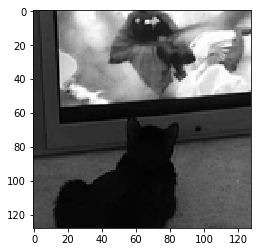

In [8]:
sample_image = np.split(images[0], 2, axis=-1)
plt.imshow(sample_image[0].squeeze(), cmap='gray')

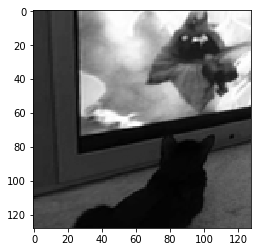

In [9]:
plt.imshow(sample_image[1].squeeze(), cmap='gray')

In [10]:
sample_offset = offsets[0]
print('sample offset: ', sample_offset)

sample offset:  [ -4  -6 -29 -12  -3 -23  -2  24]


The offset represents the displacement x,y with respect to the patch corner points

In [11]:
#data loading in Keras (credits: baudm)

def data_loader(path, batch_size=64):
    """Generator to be used with model.fit_generator()"""
    while True:
        for npz in glob.glob(os.path.join(path, '*.npz')):
            # Load pack into memory
            archive = np.load(npz)
            images = archive['images']
            offsets = archive['offsets']
            # Yield minibatch
            for i in range(0, len(offsets), batch_size):
                end_i = i + batch_size
                try:
                    batch_images = images[i:end_i]
                    batch_offsets = offsets[i:end_i]
                except IndexError:
                    continue
                # Normalize
                batch_images = (batch_images - 127.5) / 127.5
                batch_offsets = batch_offsets / 32.
                yield batch_images, batch_offsets
                

In [12]:
from keras import backend as K

#Loss Function using SMSE
def euclidean_l2(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))


In [13]:
samples_per_archive = images.shape[0]
print('samples per archive: ', samples_per_archive)

samples per archive:  9216


## Training
The python script below is the training model.

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, InputLayer
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import optimizers
import tensorflow as tf

# Dataset-specific
train_data_path = 'dataset/training'
test_data_path = 'dataset/test'
samples_per_archive = 9216
num_archives = 40
# 43 archives x 9,216 samples per archive, but use just 40 and save the 3 for testing
num_samples = num_archives * samples_per_archive


# From the paper
batch_size = 64
total_iterations = 90000

steps_per_epoch = num_samples / batch_size # As stated in Keras docs
epochs = int(total_iterations / steps_per_epoch)

input_shape = (128, 128, 2)
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.5


model = Sequential()
model.add(InputLayer(input_shape))
model.add(Conv2D(filters=filters,\
        kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=filters,\
        kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,\
        kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=filters,\
        kernel_size=kernel_size, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters*2,\
        kernel_size=kernel_size, activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(Conv2D(filters=filters*2,\
        kernel_size=kernel_size, activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters*2,\
        kernel_size=kernel_size, activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(Conv2D(filters=filters*2,\
        kernel_size=kernel_size, activation='relu', padding='same',))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(dropout))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(dropout))
#for regression model
model.add(Dense(8))
#model.add(Activation('softmax'))
model.summary()

#use optimizer Stochastic Gradient Methond with a Learning Rate of 0.005 and momentum of 0.9
#sgd = optimizers.SGD(lr=0.005, momentum=0.9, decay=0.001355)
sgd = optimizers.SGD(lr=0.005, momentum=0.9)

#compile model
model.compile(loss=euclidean_l2,\
        optimizer=sgd, metrics=['mean_squared_error'])

#check point
filepath = "checkpoints/weights-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1)
callback_list = [checkpoint]

# Train
print('TRAINING...')
model.fit_generator(data_loader(train_data_path, batch_size),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs, callbacks=callback_list)


### Model Summary
<img src="files/Model Summary.png">

### Below is the screenshot of the training results for 15 epochs

<img src="files/Training Result.png">

## Testing / Evaluation
The python script below is used to evaluate our trained model with the 3 test archives (3 x 9216 samples).

In [22]:
%ls -l checkpoints

 Volume in drive C has no label.
 Volume Serial Number is 4A9E-AED8

 Directory of C:\Users\Richard Guinto\msee


 Directory of C:\Users\Richard Guinto\msee\checkpoints

10/23/2017  06:55 PM    <DIR>          .
10/23/2017  06:55 PM    <DIR>          ..
10/23/2017  06:37 AM       273,658,120 weights-01-1.08.hdf5
10/23/2017  06:37 AM       273,658,120 weights-02-0.86.hdf5
10/23/2017  06:38 AM       273,658,120 weights-03-0.77.hdf5
10/23/2017  06:38 AM       273,658,120 weights-04-0.72.hdf5
10/23/2017  06:38 AM       273,658,120 weights-05-0.68.hdf5
10/23/2017  06:38 AM       273,658,120 weights-06-0.66.hdf5
10/23/2017  06:39 AM       273,658,120 weights-07-0.64.hdf5
10/23/2017  06:39 AM       273,658,120 weights-08-0.62.hdf5
10/23/2017  06:39 AM       273,658,120 weights-09-0.61.hdf5
10/22/2017  08:58 PM       273,658,120 weights-10-0.60.hdf5
10/23/2017  06:40 AM       273,658,120 weights-11-0.58.hdf5
10/23/2017  06:40 AM       273,658,120 weights-12-0.57.hdf5
10/23/2017  06:40 AM       

File Not Found


In [ ]:
from keras.models import load_model
from keras import optimizers

#Model Checkpoint
checkpoint = "checkpoints/weights-14-0.56.hdf5"
test_data_path = "datasets/test"

test_samples = 3 * samples_per_archive
batch_size = 64
steps = test_samples / batch_size

# load model
model = load_model(checkpoint, custom_objects={'euclidean_l2': euclidean_l2})

#use optimizer Stochastic Gradient Methond with a Learning Rate of 0.005 and momentum of 0.9
sgd = optimizers.SGD(lr=0.005, momentum=0.9)

#compile model
model.compile(loss=euclidean_l2,\
        optimizer=sgd, metrics=['mean_squared_error'])

# Test
score = model.evaluate_generator(data_loader(test_data_path, batch_size),
                         steps=steps)

print('Test score:', score)


## Prediction samples
This python code shows the prediction results with the first 10 samples of the test archive.
The result of each prediction is a normalized value (-1 to 1).  To get the actual offset value, we multiply the result by 32 (p = 32 in the paper).
Mean Square Error is used for our metrics, while Root Mean Square Error is used for the loss function.
On Mean Average Corner Error is still less than the 9.2pixel average described in the paper.

In [33]:
from keras.models import load_model

#checkpoint
checkpoint = "checkpoints/weights-14-0.56.hdf5"

# load model
print('Loading model... ', checkpoint)
model = load_model(checkpoint, custom_objects={'euclidean_l2': euclidean_l2})

for idx in range(10):
    print('SAMPLE ', idx)
    sample_image = images[idx];
    sample_shape = sample_image.shape
    sample_image = sample_image.reshape(1, 128, 128, 2)
    sample_offset = offsets[idx];
    print('Sample Offset: ', sample_offset)
    norm_sample_image = (sample_image - 127.5) / 127.5
    norm_sample_offset = sample_offset / 32.
    print('Normalize Sample Offset: ', norm_sample_offset)

    print('Predicting Offset...')
    norm_pred_offset = model.predict(norm_sample_image)
    print('Predicted Offset(Normalize): ', norm_pred_offset)
    pred_offset = norm_pred_offset * 32.
    print('Predicted Offset: ', pred_offset)
    rmse = np.sqrt(np.sum(np.square(norm_pred_offset - norm_sample_offset),axis=-1,keepdims=True))
    print('Normalize RMSE: ', rmse)
    norm_mse = np.mean(np.square(norm_pred_offset - norm_sample_offset), axis=-1, keepdims=True)
    print('Normalize MSE: ', norm_mse)
    mse = np.mean(np.square(pred_offset - sample_offset), axis=-1, keepdims=True)
    print('MSE: ', mse)
    norm_mae = np.mean(np.absolute(norm_pred_offset - norm_sample_offset), axis=-1, keepdims=True)
    print('Normalize MAE: ', norm_mae)
    mae = np.mean(np.absolute(pred_offset - sample_offset), axis=-1, keepdims=True)
    print('MAE: ', mae)
    sum = 0
    for i in range(0, len(sample_offset),2):
        h = np.square(pred_offset[0][i] - sample_offset[i]) + np.square(pred_offset[0][i+1] - sample_offset[i+1])
        h = np.sqrt(h)
        #print('h: ', h)
        sum = sum + h
    mace = sum / (len(sample_offset) / 2)
    print('Mean Ave. Corner Error: ', mace)


Loading model...  checkpoints/weights-14-0.56.hdf5
SAMPLE  0
Sample Offset:  [ -4  -6 -29 -12  -3 -23  -2  24]
Normalize Sample Offset:  [-0.125   -0.1875  -0.90625 -0.375   -0.09375 -0.71875 -0.0625   0.75   ]
Predicting Offset...
Predicted Offset(Normalize):  [[-0.14250475 -0.05554018 -0.92104042 -0.36435172 -0.11278056 -0.63863069
  -0.19482951  0.59375417]]
Predicted Offset:  [[ -4.56015205  -1.77728581 -29.4732933  -11.65925503  -3.60897803
  -20.43618202  -6.23454428  19.00013351]]
Normalize RMSE:  [[ 0.25837391]]
Normalize MSE:  [[ 0.00834463]]
MSE:  [[ 8.54490576]]
Normalize MAE:  [[ 0.07032856]]
MAE:  [[ 2.25051391]]
Mean Ave. Corner Error:  3.50753724314
SAMPLE  1
Sample Offset:  [ 27 -28  -7  -6 -31 -20  -5   3]
Normalize Sample Offset:  [ 0.84375 -0.875   -0.21875 -0.1875  -0.96875 -0.625   -0.15625  0.09375]
Predicting Offset...
Predicted Offset(Normalize):  [[ 0.60214853 -0.70988363 -0.21000905 -0.03854291 -0.65358949 -0.66570729
  -0.03431126 -0.10413262]]
Predicted Offs